## Covid 19 Predictions for Romania and EU based on diffusion of innovation process 

##### Background:

The model is taken from a marketing paper by Emmanuelle Le Nagard and Alexandre Steyer, that attempts to reflect the social structure of a diffusion process. Their application was the diffusion of innovations, not epidemics. However, there are commonalities in both domains, as the number of contacts each infected/adopter has seems relevant. It also has the added benefit to allow fitting parameters to the beginning of a time series.

Paper is available here (in French):
https://www.jstor.org/stable/40588987

The model is also sensitive to when we define the origin of time for the epidemic process. Here, it is taken the first point of the time series available, but adding a lag parameter could be attempted.

Source of the original notebook: https://www.kaggle.com/alixmartin/covid-19-predictions \
Source of the data: https://www.kaggle.com/imdevskp/corona-virus-report#covid_19_clean_complete.csv

### Import libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

from scipy.optimize import minimize

import warnings
import datetime
warnings.filterwarnings('ignore')

### Import and process data

In [2]:
# importing datasets
full_table = pd.read_csv('./DataSources/covid_19_clean_complete.csv', 
                         parse_dates=['Date'])
full_table.tail()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
16061,Bermuda,United Kingdom,32.3078,-64.7505,2020-03-19,2,0,0
16062,NaN,Chad,15.4542,18.7322,2020-03-19,1,0,0
16063,NaN,El Salvador,13.7942,-88.8965,2020-03-19,1,0,0
16064,NaN,Fiji,-17.7134,178.0650,2020-03-19,1,0,0
16065,NaN,Nicaragua,12.8654,-85.2072,2020-03-19,1,0,0


In [3]:
# aggregate data at country level and at world level
full_table = full_table.groupby([pd.Grouper(key='Date',freq='D'),
                                     'Country/Region']).agg({'Confirmed':'sum', 'Deaths':'sum', 'Recovered':'sum'})
full_table = full_table.reset_index()

In [4]:
def get_time_series(country, predict):
    df = full_table[(full_table['Country/Region'] == country)]
    df = df[df[predict] >=5]    
    return df.set_index('Date')[[predict]]

### Model definition

In [5]:
import math
def model(N, a, alpha, t):
    # we enforce N, a and alpha to be positive numbers using min and max functions
    return max(N, 0) * (1 - math.e ** (min(-a, 0) * t)) ** max(alpha, 0)

In [6]:
def model_loss(params):
    N, a, alpha = params
    model_x = []
    r = 0
    for t in range(len(df)):
        r += (model(N, a, alpha, t) - df.iloc[t, 0]) ** 2
#        print(model(N, a, alpha, t), df.iloc[t, 0])
    return r 

We need to explore the 3d parameter space to find a minimum, using gradient descent. There are a number of algorithms to do that in scipy.optimize. Here, Nelder-Mead method is used.

In [7]:
# Define model fit and extended curve functions
def display_fit(df, opt, ax):
    model_x = []
    for t in range(len(df)):
        model_x.append([df.index[t], model(*opt, t)])
    model_sim = pd.DataFrame(model_x, dtype=int)
    model_sim.set_index(0, inplace=True)
    model_sim.columns = ['model']
    return pd.concat([model_sim, df], axis=1).plot(ax=ax, figsize=(5, 4))

def display_extended_curve(df, opt, ax, n_days):
    start_date = df.index[0]
    extended_model_x = []
    for t in range(n_days):
        extended_model_x.append([start_date + datetime.timedelta(days=t), model(*opt, t)])
    extended_model_sim = pd.DataFrame(extended_model_x, dtype=int)
    extended_model_sim.set_index(0, inplace=True)
    extended_model_sim.columns = ['model']
    return pd.concat([extended_model_sim, df], axis=1).plot(ax=ax, figsize=(12, 8))

### Making predictions at country level - confirmed cases

In [8]:
country = 'Romania'
predict = 'Confirmed'
days_forecast = 180

In [9]:
# retreive country data
df = get_time_series(country, predict)
df.columns = [df.columns[0] + ' ' + country]
df.tail()

,Confirmed Romania
Date,
2020-03-15,131
2020-03-16,158
2020-03-17,184
2020-03-18,260
2020-03-19,277


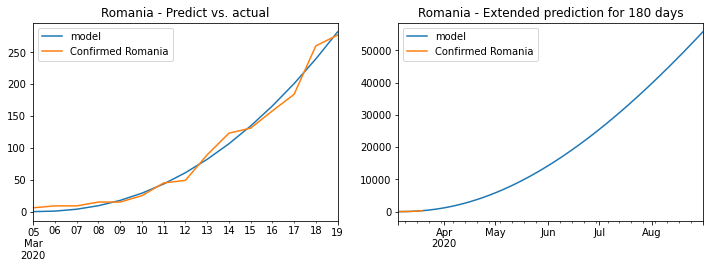

In [10]:
# make predictions for selected country
stats = []
opt = minimize(model_loss, x0=np.array([200000, 0.1, 15]), method='Nelder-Mead', tol=1e-5).x
if min(opt) > 0:
    stats.append([country, *opt])
    n_plot = len(stats)
    plt.figure(1)
    ax1 = plt.subplot(221)
    display_fit(df, opt, ax1)
    ax1.set_title(f'{country} - Predict vs. actual')
    ax2 = plt.subplot(222)
    display_extended_curve(df, opt, ax2, days_forecast)
    ax2.set_title(f'{country} - Extended prediction for {days_forecast} days')     
    plt.show()

#### See predictions at the end of each month

In [11]:
start_date = df.index[0]
extended_model_x = []
for t in range(days_forecast):
    extended_model_x.append([start_date + datetime.timedelta(days=t), model(*opt, t)])
extended_model_sim = pd.DataFrame(extended_model_x, dtype=int)
extended_model_sim.set_index(0, inplace=True)
extended_model_sim.columns = ['model']
pd.options.display.float_format = '{:20,.0f}'.format
concat_df = pd.concat([df, extended_model_sim], axis=1)
concat_df[concat_df.index.day % 30 == 0].astype({'model': 'int32'})

,Confirmed Romania,model
2020-03-30,nan,1001
2020-04-30,nan,5615
2020-05-30,nan,13589
2020-06-30,nan,25046
2020-07-30,nan,38774
2020-08-30,nan,55192


### Making predictions for different countries for comparison - confirmed cases

In [12]:
country_list = ['China', 'Korea, South', 'Italy', 'Spain', 'Germany', 'France']
predict = 'Confirmed'
days_forecast = 180

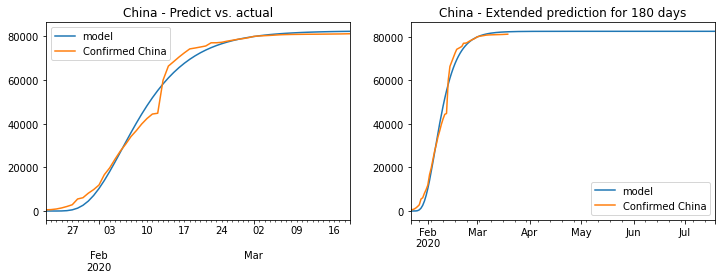

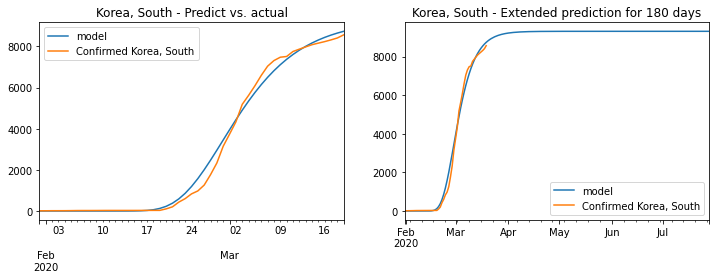

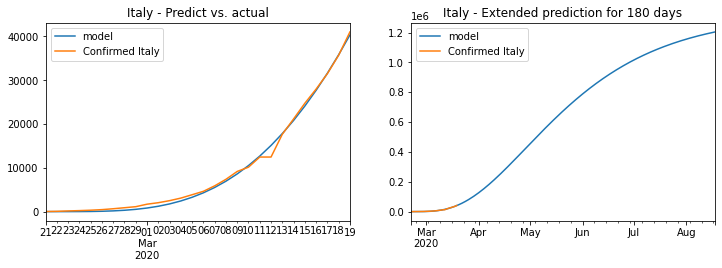

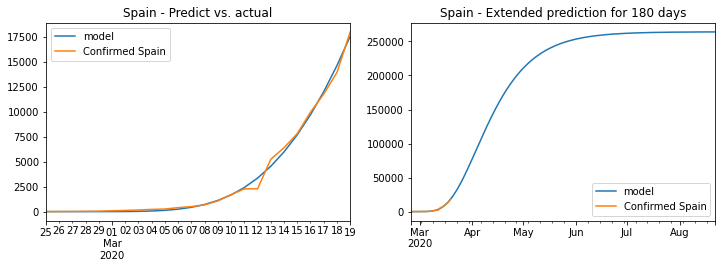

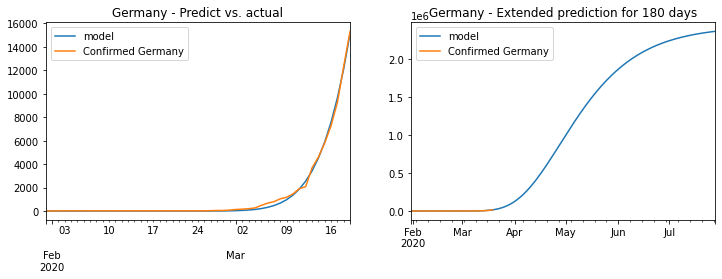

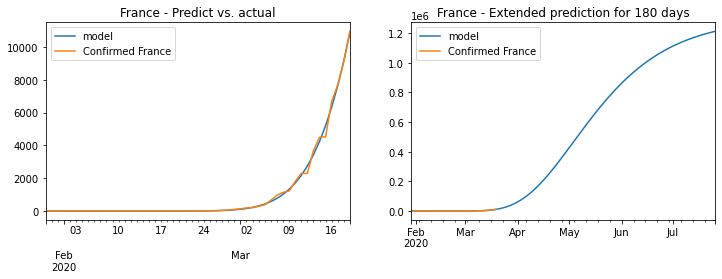

In [13]:
stats = []
for country in country_list:
    df = get_time_series(country, predict)
    df.columns = [df.columns[0] + ' ' + country]
    opt = minimize(model_loss, x0=np.array([200000, 0.1, 15]), method='Nelder-Mead', tol=1e-5).x
    if min(opt) > 0:
        stats.append([country, *opt])
        n_plot = len(stats)
        plt.figure(1)
        ax1 = plt.subplot(221)
        display_fit(df, opt, ax1)
        ax1.set_title(f'{country} - Predict vs. actual')
        ax2 = plt.subplot(222)
        display_extended_curve(df, opt, ax2, days_forecast)
        ax2.set_title(f'{country} - Extended prediction for {days_forecast} days')    
        plt.show()
stats_df = pd.DataFrame(stats)
stats_df.columns = ['country', 'N', 'a', 'alpha']

### Main conclusions:
    - China has already hit the plateau, with no significant new cases added already from March, while South Korea is accelerating in closing the gap, with expectations to reach the peak in April (i.e. peak meaning no new confirmed cases)
    
    - oddly enough, Italy and Spain are actually at the beginning of the exponential curve, however with significant differences: for Spain the maximum no. of cases (250ths) is expected to be hit in July, while for Italy, the curve is still progressing even after August, when 1.2 Mio cases are estimated if the current trend is maintained and the quarantine measures don't prove to be successful
    
    - France and Germany are also at the beginning of the phase, with estimations of 1.2 Mio confirmed cases for France and 2.2 Mio confirmed cases for Germany by end of August. These two countries seem to follow a similar pattern to Italy, with estimates to hit the plateau after August
       
    - from China and South Korea, who seem that are the most evolved ones in terms of containing the virus, we can see that the average period of the epidemic is ranging between 3 to 4 months. This hypothesis however is not sustained by the evolution in the European countries, where the period seems to be at least double at the current infection rates. 
    
    - in case of Romania, although there is a rather low number of cases, the model also suggests that we are in the beginning of the phase; the estimates here are 13.5ths confirmed cases by May and 55ths confirmed cases by August. However, given the fact that the testing is done in a very contained way (i.e. - max. 2000 tests/day capacity), we suspect here that the actual trend is higher, but not reported. With the current data, the estimates to hit the plateau are longer in the future (at least 1 year from now), which is not correlated with the evolution in the rest of the countries. This makes us conclude that the actual confirmed rate is significantly higher, thus generating significant problems of containing the spread in the future - considering that the most successful countries in containing the virus (i.e. South Korea) have done so through an entirely opposite approach: extensive testing and without city lockdowns - see below.
        
#### What is the secret for the successful countries? Extensive testing:

    - South Korea - most expansive and well-organized testing program in the world, without any city lock-downs:
    https://www.sciencemag.org/news/2020/03/coronavirus-cases-have-dropped-sharply-south-korea-whats-secret-its-success
    
    - Italy - in small communities in Italy where extensive testing was performed and the positive cases properly handled, the new confirmed cases went to 0:
    https://www.theguardian.com/world/2020/mar/18/scientists-say-mass-tests-in-italian-town-have-halted-covid-19
      
#### Disclaimers:
    - the forecast doesn't take into account the newly quarantined measures undertaken by a large number of countries and their effectiveness, the possible implications of higher temperatures, new medicine developed or other seasonality events as it is based on a model which tries to estimate the contagion effect through a diffusion process in order to assess the maximum contagion level and its spread over time for the first wave (subsequent re-ocurrence is not addressed).

In [14]:
pd.set_option('display.max_rows', 500)
pd.options.display.float_format = '{:20,.4f}'.format
stats_df.astype({'N': 'int'}).sort_values(by='N', ascending=False)

,country,N,a,alpha
4,Germany,2433630,0.0389,30.1970
2,Italy,1320087,0.0215,4.2475
5,France,1301028,0.0318,20.9141
3,Spain,264122,0.0544,8.0409
0,China,82478,0.1392,7.2847
1,"Korea, South",9310,0.1443,64.5278


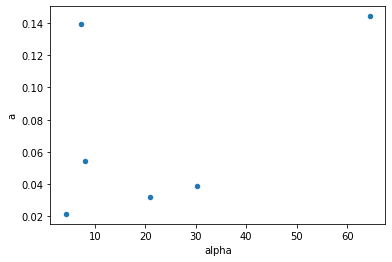

In [15]:
ax = stats_df.plot.scatter(x='alpha', y='a')
# ax.set_xlim([0, 100])
plt.show()